## Метрические методы классификации


### Цель работы

изучение принципов построения информационных систем с использованием метрических методов классификации.

### Задачи 

 - изучение инструментария Python для реализации алгоритмов метрической классификации;
 - изучение методов оптимизации параметров метрической классификации;
 - освоение модификаций kNN-метода.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### Ход работы
#### 1 Подготовка данных

In [2]:
data_source = "./Titanic-Dataset.csv"
data = pd.read_csv(data_source, delimiter=',')
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
data.rename(columns={"Sex": 'IsFemale'}, inplace=True)
data.replace({'IsFemale': {'female': 1, 'male': 0}}, inplace=True)

feats = ['Pclass', 'IsFemale', 'Age', 'SibSp', 'Parch', 'Fare']
target = 'Survived'

for feat in feats:
    mean = data[feat].mean()
    data[feat].fillna(mean, inplace=True)
    
data[[*feats, target]].head(10)

,Pclass,IsFemale,Age,SibSp,Parch,Fare,Survived
0,3,0,22.000000,1,0,7.2500,0
1,1,1,38.000000,1,0,71.2833,1
2,3,1,26.000000,0,0,7.9250,1
3,1,1,35.000000,1,0,53.1000,1
4,3,0,35.000000,0,0,8.0500,0
5,3,0,29.699118,0,0,8.4583,0
6,1,0,54.000000,0,0,51.8625,0
7,3,0,2.000000,3,1,21.0750,0
8,3,1,27.000000,0,2,11.1333,1
9,2,1,14.000000,1,0,30.0708,1


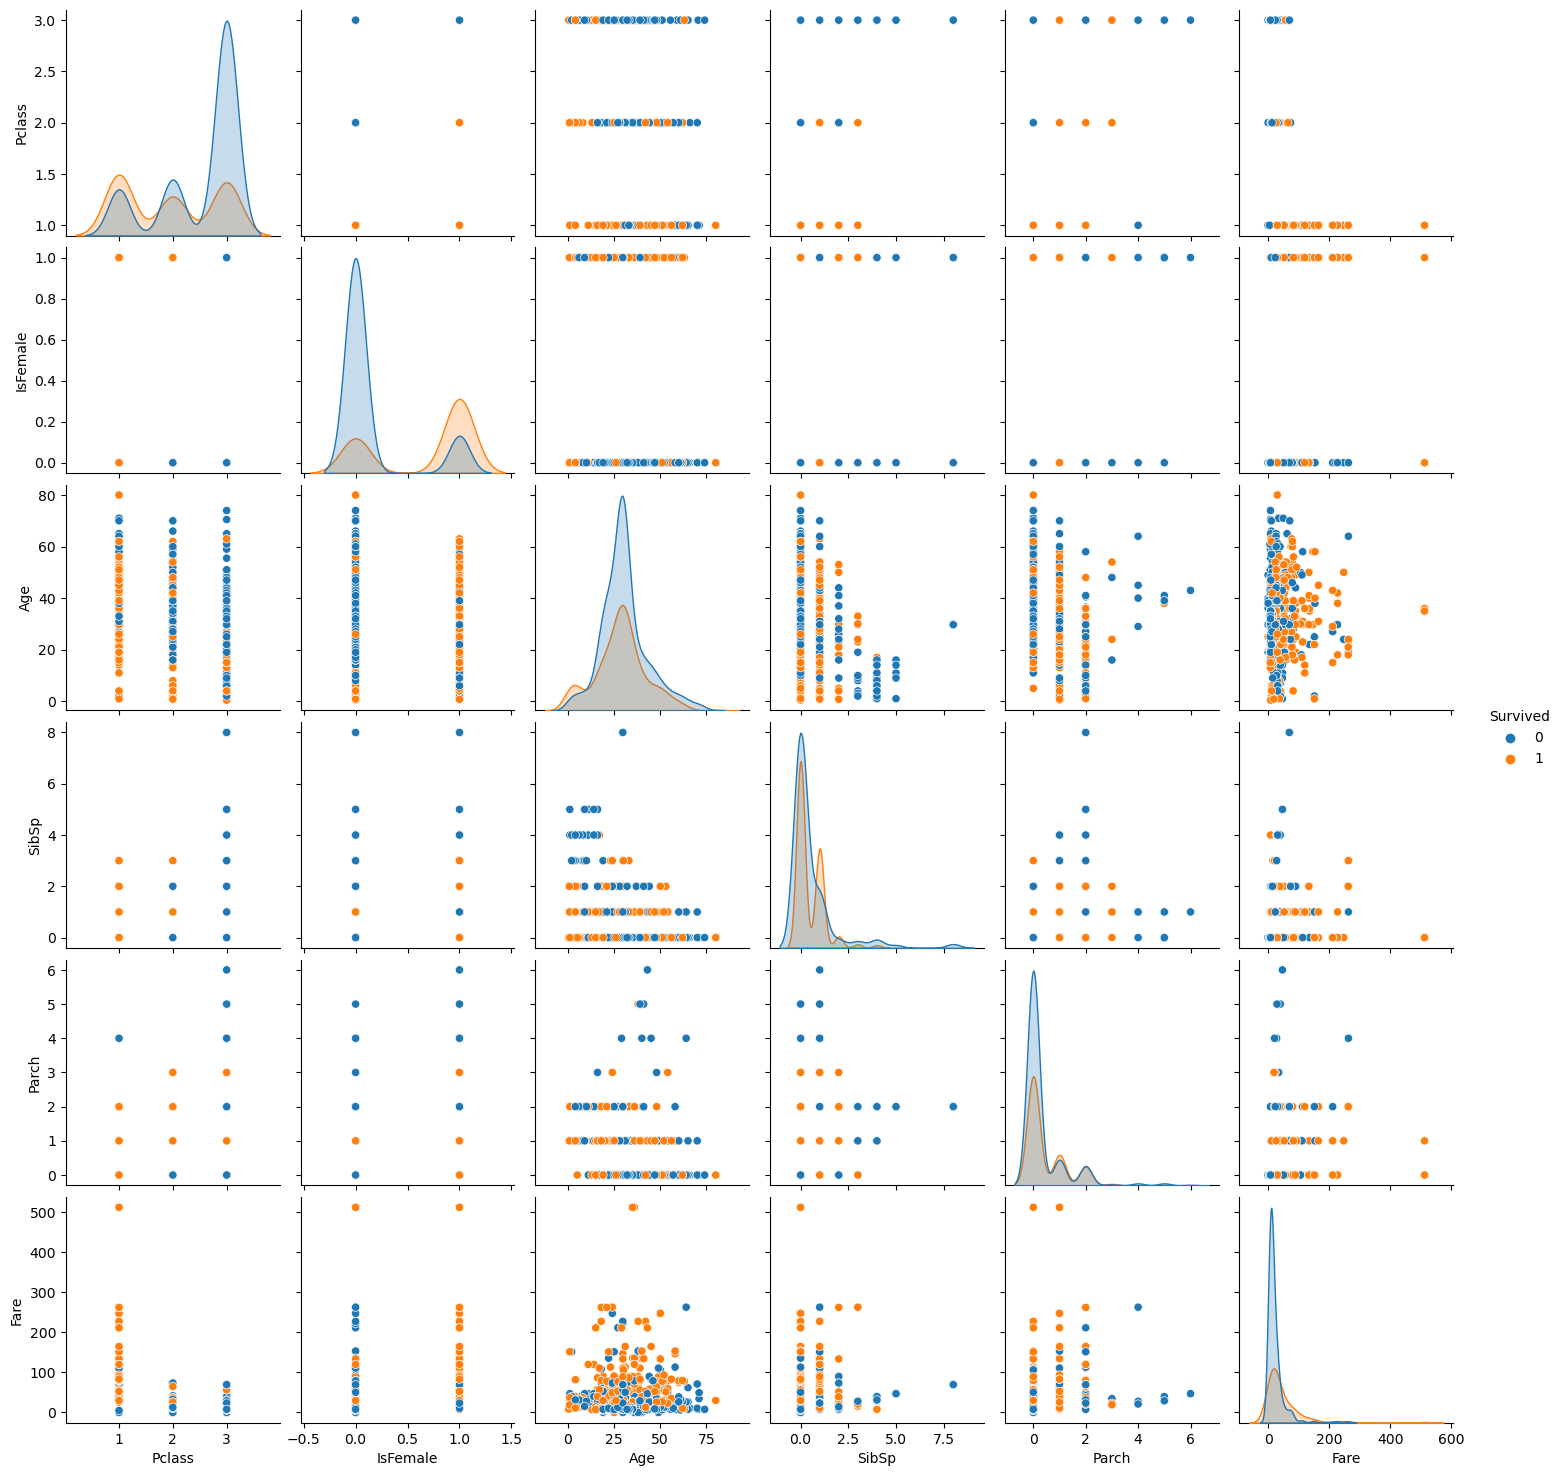

In [4]:
sns.pairplot(data[[*feats, target]], hue=target)

#### 2 Построение модели классификации на основе метода ближайших соседей

2.1 Построение классификатора с заданием K (количества ближайших соседей) пользователем

In [19]:
from sklearn.neighbors import KNeighborsClassifier

X_train = data[feats].values
y_train = data[target].values

k = 3

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

y = knn.predict(np.array([[3, 1, 22, 0, 0, 8]]))[0]
print(y)

1


2.2 Вычисление оценки hold-out для различнх значений K, а также для различных долей обучающей и тестирующей подвыборок

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

K = list(range(1, 12))
test_parts = [0.2, 0.4, 0.6, 0.8]
accuracy = []
for i, k in enumerate(K):
    accuracy.append([])
    for test_part in test_parts:
        X_train, X_holdout, y_train, y_holdout = train_test_split(
            data[feats], 
            data[target], 
            test_size=test_part, 
            random_state=42
        )
        
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        knn_pred = knn.predict(X_holdout)
        accur = accuracy_score(y_holdout, knn_pred)
        accuracy[i].append(accur)

accuracy_data = pd.DataFrame(
    accuracy, 
    columns=[f"test_size={test_part}" for test_part in test_parts],
    index=[f"K={k}" for k in K]
)
print(accuracy_data)

      test_size=0.2  test_size=0.4  test_size=0.6  test_size=0.8
K=1        0.670391       0.652661       0.620561       0.619916
K=2        0.659218       0.669468       0.646729       0.654979
K=3        0.681564       0.697479       0.678505       0.629734
K=4        0.715084       0.680672       0.684112       0.661992
K=5        0.692737       0.689076       0.657944       0.645161
K=6        0.720670       0.677871       0.665421       0.690042
K=7        0.709497       0.703081       0.682243       0.663394
K=8        0.687151       0.689076       0.676636       0.660589
K=9        0.698324       0.703081       0.689720       0.670407
K=10       0.687151       0.683473       0.678505       0.667602
K=11       0.720670       0.694678       0.676636       0.670407


2.3 Вычисление оценки cross validation для различных значений K, а также для различных значений fold (количества подмножеств при кроссвалидации)

In [45]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

K = list(range(1, 12))
cvs = list(range(2, 12))
misclassif_errs = []
for i, k in enumerate(K):
    misclassif_errs.append([])
    for cv in cvs:
        knn = KNeighborsClassifier(n_neighbors=k)

        scores = cross_val_score(
            knn, 
            data[feats], 
            data[target], 
            cv=cv, 
            scoring='accuracy'
        )
        
        misclassif_err = 1 - scores.mean()
        misclassif_errs[i].append(misclassif_err)

misclassif_err_data = pd.DataFrame(
    misclassif_errs, 
    columns=[f"cv={cv}" for cv in cvs], 
    index=[f"K={k}" for k in K])
print(misclassif_err_data)

          cv=2      cv=3      cv=4      cv=5      cv=6      cv=7      cv=8  \
K=1   0.355807  0.322110  0.323244  0.326521  0.323206  0.307429  0.309695   
K=2   0.326593  0.318743  0.314245  0.318662  0.303034  0.304081  0.304064   
K=3   0.329947  0.309764  0.305256  0.301852  0.300774  0.290556  0.287233   
K=4   0.327727  0.309764  0.307488  0.298487  0.304160  0.296207  0.296221   
K=5   0.309740  0.305275  0.310851  0.304086  0.299655  0.301814  0.291667   
K=6   0.314246  0.306397  0.325430  0.319792  0.312020  0.306357  0.309725   
K=7   0.313110  0.305275  0.308574  0.302956  0.295113  0.300671  0.295105   
K=8   0.320973  0.306397  0.315341  0.314186  0.308642  0.322009  0.313083   
K=9   0.325450  0.312009  0.309715  0.305210  0.307478  0.305162  0.305180   
K=10  0.319844  0.316498  0.316457  0.304068  0.307485  0.306278  0.302938   
K=11  0.326568  0.309764  0.314194  0.311920  0.309700  0.304037  0.297338   

          cv=9     cv=10     cv=11  
K=1   0.307520  0.309713  

2.4 Вычисление оптимальных значений гиперпараметра K и использование модели

In [52]:
MSE = []
for key in misclassif_err_data:
    MSE.append(min(misclassif_err_data[key].values))

k_min = min(MSE)
all_k_min = []
for i in range(len(MSE)):
    if MSE[i] <= k_min:
        all_k_min.append(K[i])

print('Оптимальные значения K: ', all_k_min)

Оптимальные значения K:  [10]


In [53]:
from sklearn.neighbors import KNeighborsClassifier

X_train = data[feats].values
y_train = data[target].values

K = min(all_k_min)

knn = KNeighborsClassifier(n_neighbors=K)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [58]:
feats_val = []
for feat in feats:
    val = int(input(f"Enter the {feat}: "))
    feats_val.append(val)
    
X_new = np.array([feats_val])
target = knn.predict(X_new)

if target == 0:
    print('You are dead...')
elif target == 1:
    print('You are still alive!!!')

Enter the Pclass: 1
Enter the IsFemale: 0
Enter the Age: 20
Enter the SibSp: 0
Enter the Parch: 0
Enter the Fare: 88
You are still alive!!!


### Контрольные вопросы

1. Поясните особенности основных методов метрической классификации: метод ближайшего соседа, метод k ближайших соседей.
    
    Ответ: 
    - Метод ближайшего соседа:
        - Определяется ближайший объект из обучающей выборки.
        - Новому объекту присваивается класс этого ближайшего соседа.
        - Прост, но чувствителен к выбросам и может переобучаться.
    - Метод k ближайших соседей:
        - Определяется k ближайших объектов из обучающей выборки.
        - Новому объекту присваивается класс, который наиболее часто встречается среди этих k соседей.
        - Более устойчив к выбросам и шуму, и параметр k позволяет балансировать точность и склонность к переобучению.
2. Поясните основные принципы и этапы реализации метода kNN.
    
    Ответ:
    - Определение набора данных
    - Подбор оптимального гиперпараметра K (кол-во ближайших соседей)
    - Вычисление целевой функции с помощю метода m(K)
3. Поясните принцип выбора количества соседних объектов, по которым определяется принадлежность целевого объекта к результирующему классу.

    Ответ: Основной смысл в том, чтобы разделить данные (hold-out или cross validation error) на тренеровочные и тестовые(контрольные), чтобы на основе данных об эффективности модели вывести оптимальное значение.
4. В чем заключается метод парзеновского окна?

    Ответ:
    - Для каждой точки данных строится окно (обычно окружность или многомерный шар) с центром в данной точке.
    - Окно располагается над точкой данных, и его размер (ширина) настраивается так, чтобы включить определенное количество соседних точек.
    - Для оценки плотности в данной точке вычисляется, сколько точек данных находятся внутри окна.
    - Оценка плотности в данной точке
5. Назовите, какие параметры оптимизируют в методах kNN?

    Ответ: Количество ближайщих обьектов для классификации целевого обьекта